# Predicting Dengue Fever outbreaks in Singapore
### The Notebook is currently under work-in-progress
#### Contributors:
##### - Yuan Lai (https://github.com/ylurban)
##### - Diego Garzòn (https://github.com/Diegosmiles)
##### - Bilguun Turboli (https://github.com/bilguun)

In [65]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import os
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
import warnings
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import Ridge, Lasso
import itertools
plt.style.use('ggplot')
%pylab inline
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### Phase 1

Disease data from: https://data.gov.sg/dataset/weekly-infectious-bulletin-cases

Weather data from: https://www.ncdc.noaa.gov/cdo-web/datatools/findstation; http://www.weather.gov.sg/climate-historical-daily/

In [3]:
dengue = pd.read_csv('Data/CSV/weekly-infectious-bulletin-cases.csv')
np.unique(dengue.disease.values)

array(['Acute Viral hepatitis B', 'Acute Viral hepatitis C',
       'Avian Influenza', 'Campylobacterenterosis', 'Chikungunya Fever',
       'Cholera', 'Dengue Fever', 'Dengue Haemorrhagic Fever',
       'Diphtheria', 'Encephalitis', 'Haemophilus influenzae type b',
       'Hand, Foot Mouth Disease', 'Legionellosis', 'Malaria', 'Measles',
       'Melioidosis', 'Meningococcal Infection', 'Mumps',
       'Nipah virus infection', 'Paratyphoid', 'Pertussis', 'Plague',
       'Pneumococcal Disease (invasive)', 'Poliomyelitis', 'Rubella',
       'SARS', 'Salmonellosis(non-enteric fevers)', 'Typhoid',
       'Viral Hepatitis A', 'Viral Hepatitis E', 'Yellow Fever'], dtype=object)

In [4]:
# Subset to get Dengue info
dengue = dengue[(dengue.disease=='Dengue Fever')|(dengue.disease=='Dengue Haemorrhagic Fever')]
dengue.reset_index(inplace=True)

In [5]:
dengue.drop('index',axis=1,inplace=True)
dengue.head(1) # Start of records

,epi_week,disease,number_of_cases
0,2012-W01,Dengue Fever,74


In [6]:
dengue.tail(1) # End of records

,epi_week,disease,number_of_cases
437,2016-W10,Dengue Haemorrhagic Fever,1


In [7]:
dg = pd.DataFrame({'Cases':dengue.groupby('epi_week',axis=0)['number_of_cases'].sum()}).reset_index()
dg.head(1)

,epi_week,Cases
0,2012-W01,74


In [26]:
# Change source
# http://www.weather.gov.sg/climate-historical-daily/
files_=[]
data = {}
dir_ = 'Data/WeatherData'
for directory,subdirectories,files in os.walk(dir_):
    for file_ in files:
        files_.append(os.path.join(dir_, file_))
        data[file_] = pd.read_csv((dir_+'/'+file_))

In [30]:
weather = pd.concat([data[i] for i in data.keys()],axis=0,ignore_index=True)
# We only care about the daily means for temperature, rain and wind

In [31]:
weather = weather[['Station','Year','Month','Day',
    'Daily Rainfall Total (mm)','Mean Temperature (\xb0C)','Mean Wind Speed (km/h)']]
weather['Date'] = weather['Year'].astype(str)+'-'+weather['Month'].astype(str)+'-'+weather['Day'].astype(str)
weather['Date_T'] = pd.to_datetime(weather.Date,dayfirst=False).apply(lambda x: x.weekofyear)
weather['Mean Wind Speed (km/h)'] = weather['Mean Wind Speed (km/h)'].astype(str)
print (np.unique(weather['Mean Wind Speed (km/h)'].values)[-5:])
print type(weather['Mean Wind Speed (km/h)'][2])
# Non utf-8/ascii characters are causing problems: encoding is not working
for i in range(len(weather['Mean Wind Speed (km/h)'])):
    try:
        weather['Mean Wind Speed (km/h)'].iloc[i] = float(weather['Mean Wind Speed (km/h)'].iloc[i])
    except ValueError:
        weather['Mean Wind Speed (km/h)'].iloc[i] = np.nan
weather['Mean Wind Speed (km/h)'] = weather['Mean Wind Speed (km/h)'].astype(float)  
wt = pd.DataFrame({'Mean_Rainfall':weather.groupby(['Year',
                   'Date_T'],axis=0)['Daily Rainfall Total (mm)'].mean(),
                  'Mean_Temperature':weather.groupby(['Year',
                   'Date_T'],axis=0)['Mean Temperature (\xb0C)'].mean(),
                  'Mean_Wind_Speed':weather.groupby(['Year',
                   'Date_T'],axis=0)['Mean Wind Speed (km/h)'].mean()}).reset_index()
wt.head(1)
# Prepare for merger
dg['Year'] = dg.epi_week.apply(lambda x: int(str(x)[:4]))
dg['Date_T'] = dg.epi_week.apply(lambda x: int(str(x)[-2:]))
# Merge
data = dg.merge(wt,on=['Year','Date_T'],how='inner')
#data.to_csv('dengue_weather.csv')

['9.6' '9.7' '9.8' '9.9' '\x97']
<type 'str'>


,epi_week,Cases,Year,Date_T,Mean_Rainfall,Mean_Temperature,Mean_Wind_Speed
0,2012-W01,74,2012,1,13.35,26.7625,11.4875


In [32]:
data.tail()

,epi_week,Cases,Year,Date_T,Mean_Rainfall,Mean_Temperature,Mean_Wind_Speed
212,2016-W05,525,2016,5,5.571429,28.185714,11.685714
213,2016-W06,419,2016,6,0.314286,27.628571,10.542857
214,2016-W07,590,2016,7,10.428571,27.542857,11.514286
215,2016-W08,512,2016,8,10.257143,27.857143,12.342857
216,2016-W09,412,2016,9,0.000000,28.700000,16.900000


#### Analysis

#### K Means

In [ ]:
col = np.sort(np.array(data['Year'].apply(lambda x: int(x)).unique()).flatten())
dt = pd.DataFrame(np.zeros, index=sorted(data['Date_T'].unique()), columns=(col))
# Populate with values
for i in dt.columns:
    for z in dt.index:
            temporary = data[(data['Date_T']==z)&(data['Year']==i)]
            try:
                dt.loc[z,i] = temporary.Cases.values[0].astype(float)
            except IndexError: # Because of index error
                pass
# Sanity check
print dt.shape 
dt_clean = dt.dropna()
print dt_clean.shape # No missing values 
dt_clean = dt_clean[[2012,2013,2014,2015]] # Because 2016 is incomplete, has to be omitted

In [ ]:
for i in dt_clean.columns: # If some values are not numeric
    dt_clean[i] = dt_clean[i].convert_objects(convert_numeric=True)
    # Standardize dt
for i in dt_clean.index: # Standardize rows...
    dt_clean.loc[i] = (dt_clean.loc[i] - dt_clean.loc[i].mean())/dt_clean.loc[i].std()
# Find best number of clusters using the silhouette score
l = {}
for i in range(0,8): 
    est = KMeans(n_clusters = i+2, n_init = 100)
    est.fit(dt_clean.values)
    l[i] = silhouette_score(dt_clean.values, est.labels_)
    print('At {0} clusters, silhouette score is {1}'.format(i+2, l[i]))       

In [ ]:
import operator
value = max(l.iteritems(), key=operator.itemgetter(1))[0]+2 # + 2 because clusters start at 2, not at 0 as the keys do

In [ ]:
fig = plt.figure(figsize=(10,10))
kmeans = KMeans(n_clusters = value, n_init = 100)
kmeans.fit(dt_clean.values)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
ax = fig.add_subplot(111)
for a in dt_clean.index:
    plt.plot(dt_clean.loc[a].index,dt_clean.loc[a], alpha=0.4)
for b in range(len(centroids)):
    plt.plot(list(dt_clean.columns),centroids[b],linewidth=14)
ax.set_axis_bgcolor('#4C4C4C')
plt.xlim(dt_clean.columns.values.min(),dt_clean.columns.values.max())
plt.xlabel('Year',size=20)
plt.ylabel('Dengue Fever Cases',size=20)
plt.title("K Means Clustering with %i Clusters per Year" % (value), fontsize = 20)
ax.get_xaxis().tick_bottom();
locs, labels = plt.xticks();
ticks = np.arange(2012, 2015, 1);
ticks = [str(ticks[i]) for i in range(len(ticks))];
plt.grid('off')
plt.xticks(np.arange(2012, 2015, 1),ticks);
#plt.savefig('KMeans.jpg')

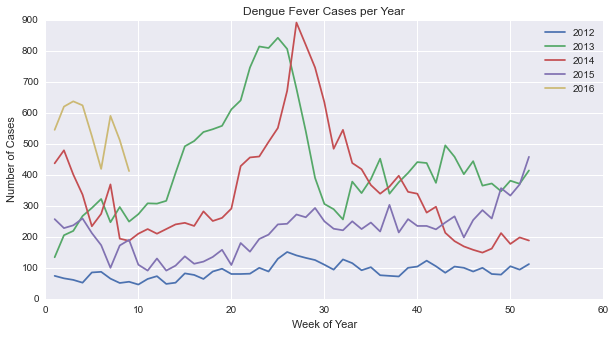

In [34]:
fig,ax = plt.subplots(figsize=(10,5))
for i in np.unique(data.Year.values):
    plt.plot(data[data.Year==i].Date_T,data[data.Year==i].Cases,label='%d'%(i));
    plt.legend();
    plt.title('Dengue Fever Cases per Year');
    plt.xlabel('Week of Year')
    plt.ylabel('Number of Cases')
plt.savefig('dengue.png')    

***As one can see, some yearly pattern emerge. During the summer months, dengue cases are generally higher, except for 2015. Another spike appears at the end of the year, during winter months.***

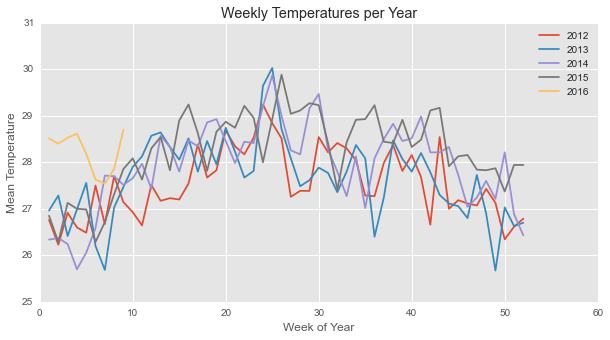

In [142]:
fig,ax = plt.subplots(figsize=(10,5))
for i in np.unique(data.Year.values):
    plt.plot(data[data.Year==i].Date_T,data[data.Year==i].Mean_Temperature,label='%d'%(i));
    plt.legend();
    plt.title('Weekly Temperatures per Year');
    plt.xlabel('Week of Year')
    plt.ylabel('Mean Temperature')
plt.savefig('temp.png')    

***At least the summer spikes coincide with higher temperatures. Let's see if this is true for wind and rainfall as well.***

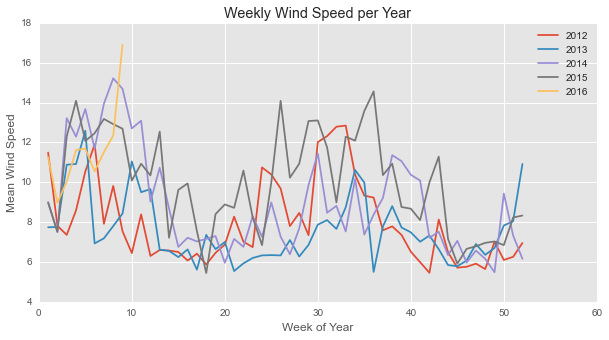

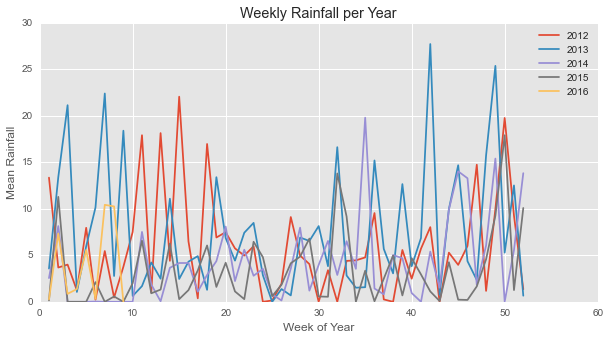

In [143]:
fig,ax = plt.subplots(figsize=(10,5))
for i in np.unique(data.Year.values):
    plt.plot(data[data.Year==i].Date_T,data[data.Year==i].Mean_Wind_Speed,label='%d'%(i));
    plt.legend();
    plt.title('Weekly Wind Speed per Year');
    plt.xlabel('Week of Year')
    plt.ylabel('Mean Wind Speed')
fig,ax = plt.subplots(figsize=(10,5))
for i in np.unique(data.Year.values):
    plt.plot(data[data.Year==i].Date_T,data[data.Year==i].Mean_Rainfall,label='%d'%(i));
    plt.legend();
    plt.title('Weekly Rainfall per Year');
    plt.xlabel('Week of Year')
    plt.ylabel('Mean Rainfall')
plt.savefig('wind.png')    

*** For rainfall, the patterns is less strong.***

In [37]:
data.drop(['Date_T','Year'],axis=1).corr()['Cases']

Cases               1.000000
Mean_Rainfall      -0.025574
Mean_Temperature    0.239157
Mean_Wind_Speed    -0.079607
Name: Cases, dtype: float64

***Indeed, the correlation matrix confirms the intuition drawn from the visualizations: Temperature is more correlated than rainfall and wind.***

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 0 to 216
Data columns (total 7 columns):
epi_week            217 non-null object
Cases               217 non-null int64
Year                217 non-null int64
Date_T              217 non-null int64
Mean_Rainfall       217 non-null float64
Mean_Temperature    217 non-null float64
Mean_Wind_Speed     217 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 13.6+ KB


In [39]:
data_clean = data.dropna()

In [40]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 0 to 216
Data columns (total 7 columns):
epi_week            217 non-null object
Cases               217 non-null int64
Year                217 non-null int64
Date_T              217 non-null int64
Mean_Rainfall       217 non-null float64
Mean_Temperature    217 non-null float64
Mean_Wind_Speed     217 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 13.6+ KB


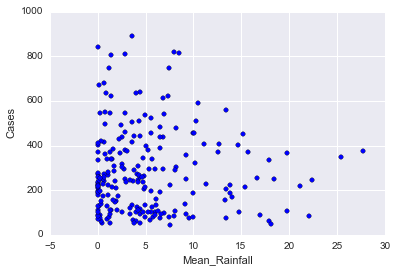

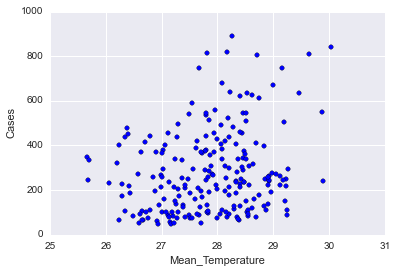

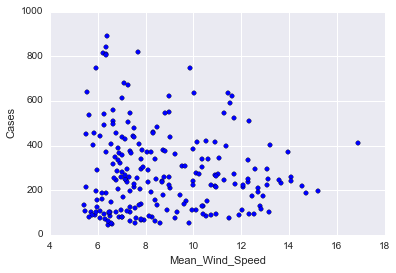

In [41]:
for i in data_clean.drop(['Date_T','Year','Cases','epi_week'],axis=1).columns:
    plt.figure()
    plt.scatter(data_clean[i],data_clean.Cases)
    plt.ylabel('Cases')
    plt.xlabel('%s'%(i))
    plt.savefig('%s.png'%(i))

In [42]:
data_clean[['Cases','Mean_Rainfall','Mean_Temperature','Mean_Wind_Speed']].describe()

,Cases,Mean_Rainfall,Mean_Temperature,Mean_Wind_Speed
count,217.000000,217.000000,217.000000,217.000000
mean,281.926267,5.194026,27.857340,8.756047
std,185.517255,5.480125,0.862754,2.433888
min,46.000000,0.000000,25.671429,5.442857
25%,125.000000,1.057143,27.242857,6.842857
50%,246.000000,3.971429,27.885714,8.042857
75%,381.000000,6.914286,28.457143,10.542857
max,891.000000,27.714286,30.028571,16.900000


In [126]:
# Use bins to reduce granularity but increase prediction accuracy

# Choose 0.5 C 
#bins_temp = np.arange(data_clean.Mean_Temperature.min()-0.1,data_clean.Mean_Temperature.max()+0.1,0.5)
# Choose 50 cases
#bins_cases = np.arange(data_clean.Cases.min()-4,data_clean.Cases.max()+4,50)
# Choose 0.5 km/h c
#bins_wind = np.arange(data_clean.Mean_Wind_Speed.min()-0.3,data_clean.Mean_Wind_Speed.max()+0.3,0.5)
# Choose 0.5 km/h c
#bins_rain = np.arange(data_clean.Mean_Rainfall.min()-1,data_clean.Mean_Rainfall.max()+1,1)
#data_clean['Cases_Bin'] = pd.cut(data_clean.Cases, bins_cases, labels=np.arange(1,len(bins_cases),1))
#data_clean['Mean_Temperature_Bin'] = pd.cut(data_clean.Mean_Temperature, bins_temp, labels=np.arange(1,len(bins_temp),1))
#data_clean['Mean_Wind_Speed_Bin'] = pd.cut(data_clean.Mean_Wind_Speed, bins_wind, labels=np.arange(1,len(bins_wind),1))
#data_clean['Mean_Rainfall_Bin'] = pd.cut(data_clean.Mean_Rainfall, bins_rain, labels=np.arange(1,len(bins_rain),1))

# Choose quantiles
data_clean['Cases_Bin'] = pd.qcut(data_clean.Cases, 5, labels=np.arange(0,5))
data_clean['Mean_Temperature_Bin'] = pd.qcut(data_clean.Mean_Temperature, 5, labels=np.arange(0,5))
data_clean['Mean_Wind_Speed_Bin'] = pd.qcut(data_clean.Mean_Wind_Speed, 5, labels=np.arange(0,5))
data_clean['Mean_Rainfall_Bin'] = pd.qcut(data_clean.Mean_Rainfall, 5, labels=np.arange(0,5))
data_clean['Mean_Rainfall_Bin'] = data_clean['Mean_Rainfall_Bin'].astype(float)
data_clean['Mean_Temperature_Bin'] = data_clean['Mean_Temperature_Bin'].astype(float)
data_clean['Mean_Wind_Speed_Bin'] = data_clean['Mean_Wind_Speed_Bin'].astype(float)

In [127]:
data_clean.head(2)

,epi_week,Cases,Year,Date_T,Mean_Rainfall,Mean_Temperature,Mean_Wind_Speed,Cases_Bin,Mean_Temperature_Bin,Mean_Wind_Speed_Bin,Mean_Rainfall_Bin
0,2012-W01,74,2012,1,13.350000,26.762500,11.487500,0,0.0,4.0,4.0
1,2012-W02,66,2012,2,3.685714,26.228571,7.814286,0,0.0,2.0,2.0


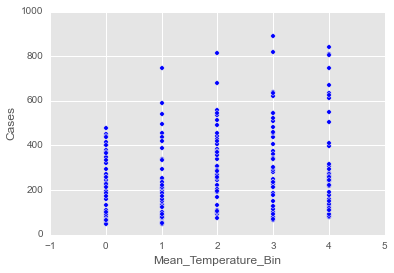

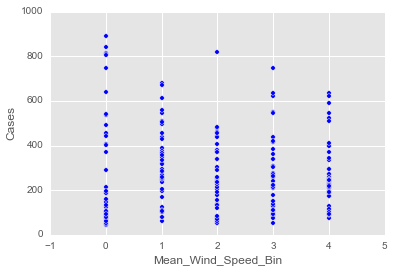

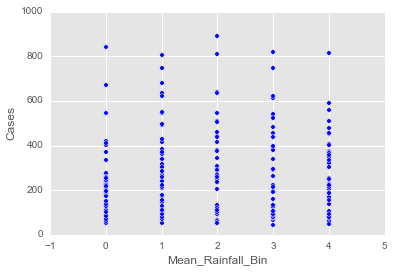

In [128]:
for i in data_clean.drop(['Date_T','Year','Cases','epi_week','Cases_Bin'],axis=1).columns:
    if i.find('Bin')!=-1:
        plt.figure()
        plt.scatter(data_clean[i],data_clean.Cases)
        plt.ylabel('Cases')
        plt.xlabel('%s'%(i))

In [129]:
# Lasso
d = []
for i in np.linspace(0,100,1000):
    lasso = Lasso(alpha=i).fit(x_train_,y_train_)
    prediction = lasso.predict(x_validation)
    err = prediction - y_validation
    R2 = 1-np.var(err)/np.var(y_validation)
    d.append((i,R2))

In [130]:
print sorted(d, key=lambda tup: tup[1])[-1]

(0.10010010010010011, 0.021250817587203485)


In [131]:
import statsmodels.formula.api as sm
result = sm.ols(formula="Cases_Bin ~ Mean_Rainfall_Bin + Mean_Temperature_Bin + Mean_Wind_Speed_Bin", data=data_clean).fit()

In [132]:
data_clean.to_csv('phase1.csv')

In [133]:
print result.summary()

                            OLS Regression Results                            
Dep. Variable:              Cases_Bin   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     4.285
Date:                Sat, 30 Apr 2016   Prob (F-statistic):            0.00582
Time:                        18:16:17   Log-Likelihood:                -378.73
No. Observations:                 217   AIC:                             765.5
Df Residuals:                     213   BIC:                             779.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept                1.1290 

In [50]:
def get_results(max_features,criterion,n_estimators,X,Y):
    kf = KFold(n=len(X), n_folds=12, shuffle=True, random_state=21)
    d = []
    for train_index, test_index in kf:
        for rf_features,criter,rf_estimators in itertools.product(max_features,criterion,n_estimators):
            X_tr, X_test = X[train_index], X[test_index]
            X_train, X_validation = train_test_split(X_tr, test_size=0.2, random_state=21)
            Y_tr, Y_test = Y[train_index], Y[test_index]
            Y_train, Y_validation = train_test_split(Y_tr, test_size=0.2, random_state=21)
            del X_tr
            del Y_tr
            forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion=criter,
                    max_depth=None, max_features=rf_features, max_leaf_nodes=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=rf_estimators, n_jobs=-1,
                    oob_score=False, random_state=21, verbose=0,
                    warm_start=False)
            forest.fit(X_train,Y_train)
            forest_pred = forest.predict(X_validation)
            name = '%s,%s,%s'%(str(rf_features),str(criter),str(rf_estimators))
            d.append((name,accuracy_score(Y_validation,forest_pred),X_train,X_test,Y_train,Y_test))
    return sorted(d, key=lambda tup: tup[1])[-1]

In [53]:
# Random Forest
max_features = ['auto','sqrt','log2']
criterion = ['gini','entropy']
n_estimators = [100,300,1000]
best = get_results(max_features,criterion,n_estimators, 
                  np.asarray(data_clean[['Mean_Rainfall_Bin','Mean_Temperature_Bin','Mean_Wind_Speed_Bin']]),
                  np.asarray(data_clean.Cases_Bin))

In [56]:
best[0]

'log2,entropy,300'

In [57]:
best_params,X_train_best,X_test_best,Y_train_best,Y_test_best = best[0].split(','),best[2],best[3],best[4],best[5]
forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion=best_params[1],
                max_depth=None, max_features=best_params[0], max_leaf_nodes=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=int(best_params[2]), n_jobs=-1,
                oob_score=False, random_state=21, verbose=0,
                warm_start=False)
forest.fit(X_train_best,Y_train_best)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=21, verbose=0, warm_start=False)

In [63]:
print 'Accuracy Score is {0}%'.format(accuracy_score(Y_test_best,forest.predict(X_test_best))*100)

Accuracy Score is 33.3333333333%


### Lag data

Because the life cycle of mosquito's lasts about 10 days, we will lag the weather related data by one week and later, by two weeks. Reference:
http://www.cdc.gov/Dengue/entomologyEcology/m_lifecycle.html

In [134]:
def shift(n, dataframe=False):
    lag = data_clean.copy()
    desired_columns = ['Mean_Rainfall','Mean_Temperature', 'Mean_Wind_Speed', 'Mean_Temperature_Bin', 
          'Mean_Wind_Speed_Bin', 'Mean_Rainfall_Bin']
    for i in desired_columns:
        lag[i] = lag[i].shift(n)
    l = list(np.arange(0,n,1) )
    for i in l:
        lag.drop(i,axis=0,inplace=True)
    if dataframe:
        return lag
    else:
        X = np.asarray(lag[['Mean_Rainfall_Bin',
                            'Mean_Temperature_Bin','Mean_Wind_Speed_Bin']])
        Y = np.asarray(lag.Cases_Bin)
        return X,Y

In [100]:
X, Y = shift(2)

In [112]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2)

In [114]:
best_params = best[0].split(',')
forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion=best_params[1],
                max_depth=None, max_features=best_params[0], max_leaf_nodes=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=int(best_params[2]), n_jobs=-1,
                oob_score=False, random_state=21, verbose=0,
                warm_start=False)
forest.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=21, verbose=0, warm_start=False)

In [115]:
print 'Accuracy Score is {0}%'.format(accuracy_score(y_test,forest.predict(x_test))*100)

Accuracy Score is 34.8837209302%


In [144]:
print forest.feature_importances_

[ 0.3284732   0.34940774  0.32211906]


In [138]:
lagged = shift(2, dataframe=True)

In [140]:
result = sm.ols(formula="Cases_Bin ~ Mean_Rainfall_Bin + Mean_Temperature_Bin + Mean_Wind_Speed_Bin", data=lagged).fit()

In [141]:
print result.summary()

                            OLS Regression Results                            
Dep. Variable:              Cases_Bin   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     6.315
Date:                Sat, 30 Apr 2016   Prob (F-statistic):           0.000403
Time:                        18:19:05   Log-Likelihood:                -371.33
No. Observations:                 215   AIC:                             750.7
Df Residuals:                     211   BIC:                             764.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept                1.1470 